Use A2C on MiniPacManV2

In [1]:
pip install gymnasium

In [2]:
from time import sleep
import numpy as np
from IPython.display import clear_output
import gymnasium as gym
from gymnasium.envs.registration import register
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [3]:
#Give colab access to your google drive:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd /gdrive/MyDrive/CSCI181V/

/gdrive/MyDrive/CSCI181V


In [21]:
#Import MiniPacMan environment class definition
from MiniPacManGym import MiniPacManEnv

In [6]:
#Register MiniPacMan in your gymnasium environments
register(
    id="MiniPacMan-v0",
    entry_point=MiniPacManEnv,  # Update with your actual module path
    max_episode_steps=20          # You can also set a default here
)

In [7]:
#Create a MiniPacMan gymnasium environment
env = gym.make("MiniPacMan-v0", render_mode="human", frozen_ghost=False)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np

# Define the Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()

        # Shared layers
        self.fc1 = nn.Linear(state_dim, 128)

        # Policy (Actor) network
        self.policy_fc = nn.Linear(128, action_dim)

        # Value (Critic) network
        self.value_fc = nn.Linear(128, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        policy_logits = self.policy_fc(x)
        value = self.value_fc(x)
        return policy_logits, value

Win Percentage: 0.00%, Loss: -6.56, Episode: 1
Win Percentage: 0.00%, Loss: -7.18, Episode: 2
Win Percentage: 0.00%, Loss: -6.47, Episode: 3
Win Percentage: 0.00%, Loss: -6.63, Episode: 4
Win Percentage: 0.00%, Loss: -7.06, Episode: 5
Win Percentage: 0.00%, Loss: -7.09, Episode: 6
Win Percentage: 0.00%, Loss: -6.82, Episode: 7
Win Percentage: 0.00%, Loss: -5.50, Episode: 8
Win Percentage: 0.00%, Loss: -5.62, Episode: 9
Win Percentage: 0.00%, Loss: -6.43, Episode: 10
Win Percentage: 0.00%, Loss: -5.68, Episode: 11
Win Percentage: 0.00%, Loss: -5.20, Episode: 12
Win Percentage: 0.00%, Loss: -6.64, Episode: 13
Win Percentage: 0.00%, Loss: -5.01, Episode: 14
Win Percentage: 0.00%, Loss: -5.60, Episode: 15
Win Percentage: 0.00%, Loss: -4.93, Episode: 16
Win Percentage: 0.00%, Loss: -5.51, Episode: 17
Win Percentage: 0.00%, Loss: -7.25, Episode: 18
Win Percentage: 0.00%, Loss: -5.20, Episode: 19
Win Percentage: 0.00%, Loss: -5.80, Episode: 20
Win Percentage: 0.00%, Loss: -4.71, Episode: 21
W

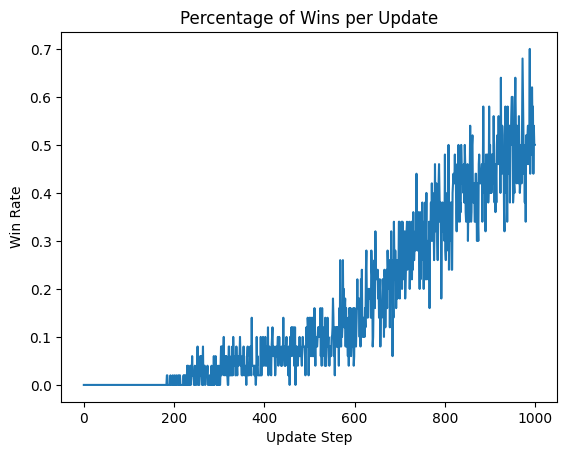

In [30]:
# Training parameters
gamma = 0.99  # Discount factor
learning_rate = 0.001
num_updates = 1000
num_trajectories = 50

# Initialize environment
env = gym.make('MiniPacMan-v0')  # Ensure correct version
state_dim = 36  # Flattened 6x6 grid
action_dim = env.action_space.n

# Initialize model and optimizer
model = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Tracking wins per update
win_rates = []

# Training loop
for update in range(num_updates):
    buffer = []
    wins = 0
    for _ in range(num_trajectories):
        state, _ = env.reset()
        done = False
        while not done:
            state_tensor = torch.tensor(state.flatten(), dtype=torch.float32).unsqueeze(0)  # Flatten input
            logits, value = model(state_tensor)

            # Sample action using policy distribution
            action_probs = F.softmax(logits, dim=-1)
            action = torch.multinomial(action_probs.flatten(), num_samples=1).item()

            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            buffer.append((state.flatten(), action, reward, next_state.flatten(), done))
            state = next_state

        # Check if Pac-Man wins (assuming positive reward means win)
        if reward > 0:
            wins += 1

    # Compute targets and advantages
    states, actions, rewards, next_states, dones = zip(*buffer)
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    # Compute targets and advantages
    _, next_values = model(next_states)
    targets = rewards + gamma * next_values.squeeze() * (1 - dones)
    _, values = model(states)
    advantages = targets - values.squeeze()

    # Compute policy loss
    logits, _ = model(states)
    log_probs = F.log_softmax(logits, dim=-1)
    action_log_probs = log_probs.gather(1, actions.unsqueeze(1)).squeeze()
    policy_loss = -(action_log_probs * advantages.detach()).mean()

    # Compute value loss
    value_loss = F.mse_loss(values.squeeze(), targets.detach())

    # Update networks
    optimizer.zero_grad()
    (policy_loss + value_loss).backward()
    optimizer.step()

    # Track win rate
    win_rate = wins / num_trajectories
    win_rates.append(win_rate)

    print(f"Win Percentage: {win_rate * 100:.2f}%, Loss: {policy_loss.item():.2f}, Episode: {update+1}")


# Plot win rates
plt.plot(range(num_updates), win_rates)
plt.xlabel('Update Step')
plt.ylabel('Win Rate')
plt.title('Percentage of Wins per Update')
plt.show()

